In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
class AnomalyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 0 if 'normal' in self.root_dir else 1  # 0 for normal, 1 for anomalous
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [6]:
# Load Datasets
normal_dataset = AnomalyDataset('../../datasets/agco_front/normal', transform=transform)
anomalous_dataset = AnomalyDataset('../../datasets/agco_front/anomalous', transform=transform)

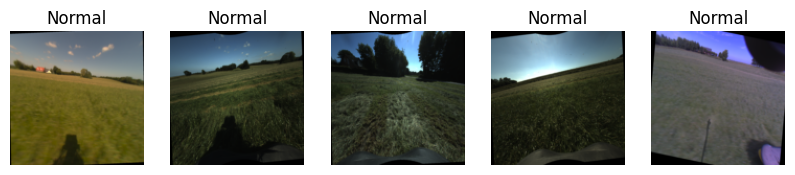

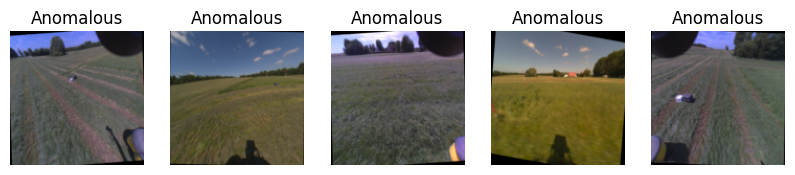

In [7]:
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Normal" if label == 0 else "Anomalous")
        plt.axis("off")
    plt.show()

visualize_images(normal_dataset)
visualize_images(anomalous_dataset)


In [9]:
total_normal_images = len(normal_dataset)
train_size = int(0.8 * total_normal_images)
val_size = total_normal_images - train_size

train_dataset, val_dataset = random_split(normal_dataset, [train_size, val_size])

In [10]:
# DataLoaders
train_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(anomalous_dataset, batch_size=32, shuffle=False)

In [11]:
# Combine val and anomalous datasets for testing
test_dataset = torch.utils.data.ConcatDataset([val_dataset, anomalous_dataset])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder()

In [13]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device, mode="Validation"):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc=mode):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
best_loss = float("inf")

In [15]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_autoencoder_model_1.pth")
        print("Best model saved!")

Validation: 100%|██████████| 24/24 [00:37<00:00,  1.56s/it]


Epoch [1/20], Train Loss: 0.0202, Val Loss: 0.0102
Best model saved!


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it]


Epoch [2/20], Train Loss: 0.0061, Val Loss: 0.0064
Best model saved!


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


Epoch [3/20], Train Loss: 0.0038, Val Loss: 0.0043
Best model saved!


Validation: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it]


Epoch [4/20], Train Loss: 0.0028, Val Loss: 0.0035
Best model saved!


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


Epoch [5/20], Train Loss: 0.0025, Val Loss: 0.0032
Best model saved!


Validation: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch [6/20], Train Loss: 0.0024, Val Loss: 0.0038


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.50s/it]


Epoch [7/20], Train Loss: 0.0020, Val Loss: 0.0026
Best model saved!


Validation: 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch [8/20], Train Loss: 0.0019, Val Loss: 0.0026
Best model saved!


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.50s/it]


Epoch [9/20], Train Loss: 0.0021, Val Loss: 0.0032


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it]


Epoch [10/20], Train Loss: 0.0017, Val Loss: 0.0024
Best model saved!


Validation: 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]


Epoch [11/20], Train Loss: 0.0016, Val Loss: 0.0022
Best model saved!


Validation: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


Epoch [12/20], Train Loss: 0.0016, Val Loss: 0.0023


Validation: 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]


Epoch [13/20], Train Loss: 0.0016, Val Loss: 0.0023


Validation: 100%|██████████| 24/24 [00:36<00:00,  1.53s/it]


Epoch [14/20], Train Loss: 0.0016, Val Loss: 0.0021
Best model saved!


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it]


Epoch [15/20], Train Loss: 0.0015, Val Loss: 0.0022


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.48s/it]


Epoch [16/20], Train Loss: 0.0015, Val Loss: 0.0020
Best model saved!


Validation: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


Epoch [17/20], Train Loss: 0.0014, Val Loss: 0.0019
Best model saved!


Validation: 100%|██████████| 24/24 [00:35<00:00,  1.50s/it]


Epoch [18/20], Train Loss: 0.0014, Val Loss: 0.0019


Validation: 100%|██████████| 24/24 [00:37<00:00,  1.58s/it]


Epoch [19/20], Train Loss: 0.0014, Val Loss: 0.0018
Best model saved!


Validation: 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]

Epoch [20/20], Train Loss: 0.0014, Val Loss: 0.0018
Best model saved!


### Testing

In [17]:
def detect_anomalies(model, dataloader, threshold, device):
    model.load_state_dict(torch.load("best_autoencoder_model_1.pth"))
    model.eval()
    labels = []
    predictions = []
    sample_images = []
    sample_preds = []
    sample_labels = []
    
    with torch.no_grad():
        for images, true_labels in tqdm(dataloader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            losses = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])
            preds = (losses > threshold).int().cpu().numpy()
            predictions.extend(preds)
            labels.extend(true_labels.numpy())

            # Saving some sample images for visualization
            sample_images.extend(images.cpu())
            sample_preds.extend(preds)
            sample_labels.extend(true_labels.cpu().numpy())
    
    return labels, predictions, sample_images, sample_preds, sample_labels



Testing: 100%|██████████| 37/37 [00:59<00:00,  1.62s/it]


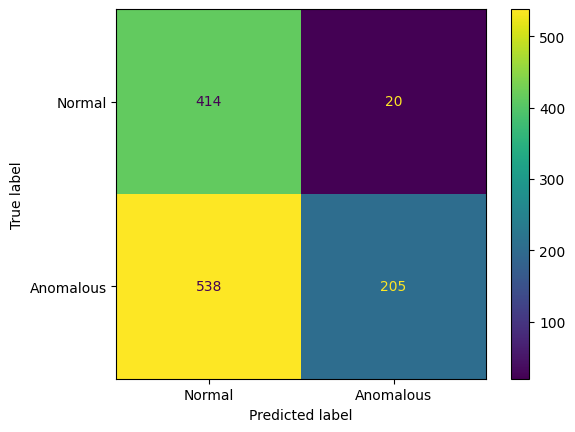

In [21]:
# threshold for anomaly detection (adjusting on val loss)
threshold = 0.0018  

labels, predictions, sample_images, sample_preds, sample_labels = detect_anomalies(model, test_loader, threshold, device)

# Confusion Matrix
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
disp.plot()
plt.show()

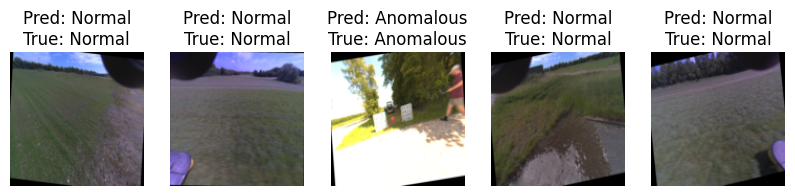

In [22]:
def visualize_predictions(images, preds, labels, num_images=5):
    # Randomly select indices for visualization
    indices = random.sample(range(len(images)), num_images)
    
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].permute(1, 2, 0))
        pred_label = "Anomalous" if preds[idx] == 1 else "Normal"
        true_label = "Anomalous" if labels[idx] == 1 else "Normal"
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis("off")
    plt.show()

# Usage
visualize_predictions(sample_images, sample_preds, sample_labels)
